In [ ]:
! pip install -U llama-cpp-python langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph

# Self RAG

Self-reflection can enhance RAG, enabling correction of poor quality retrieval or generations.

Several recent papers focus on this theme, but implementing the ideas can be tricky.

Here we show how to implement self-reflective RAG using `Nomic`, `Mistral`, and `LangGraph`.

We'll focus on ideas from one paper, `Self RAG` [here](https://arxiv.org/abs/2310.11511).

This can run fully locally (e.g., on a laptop).

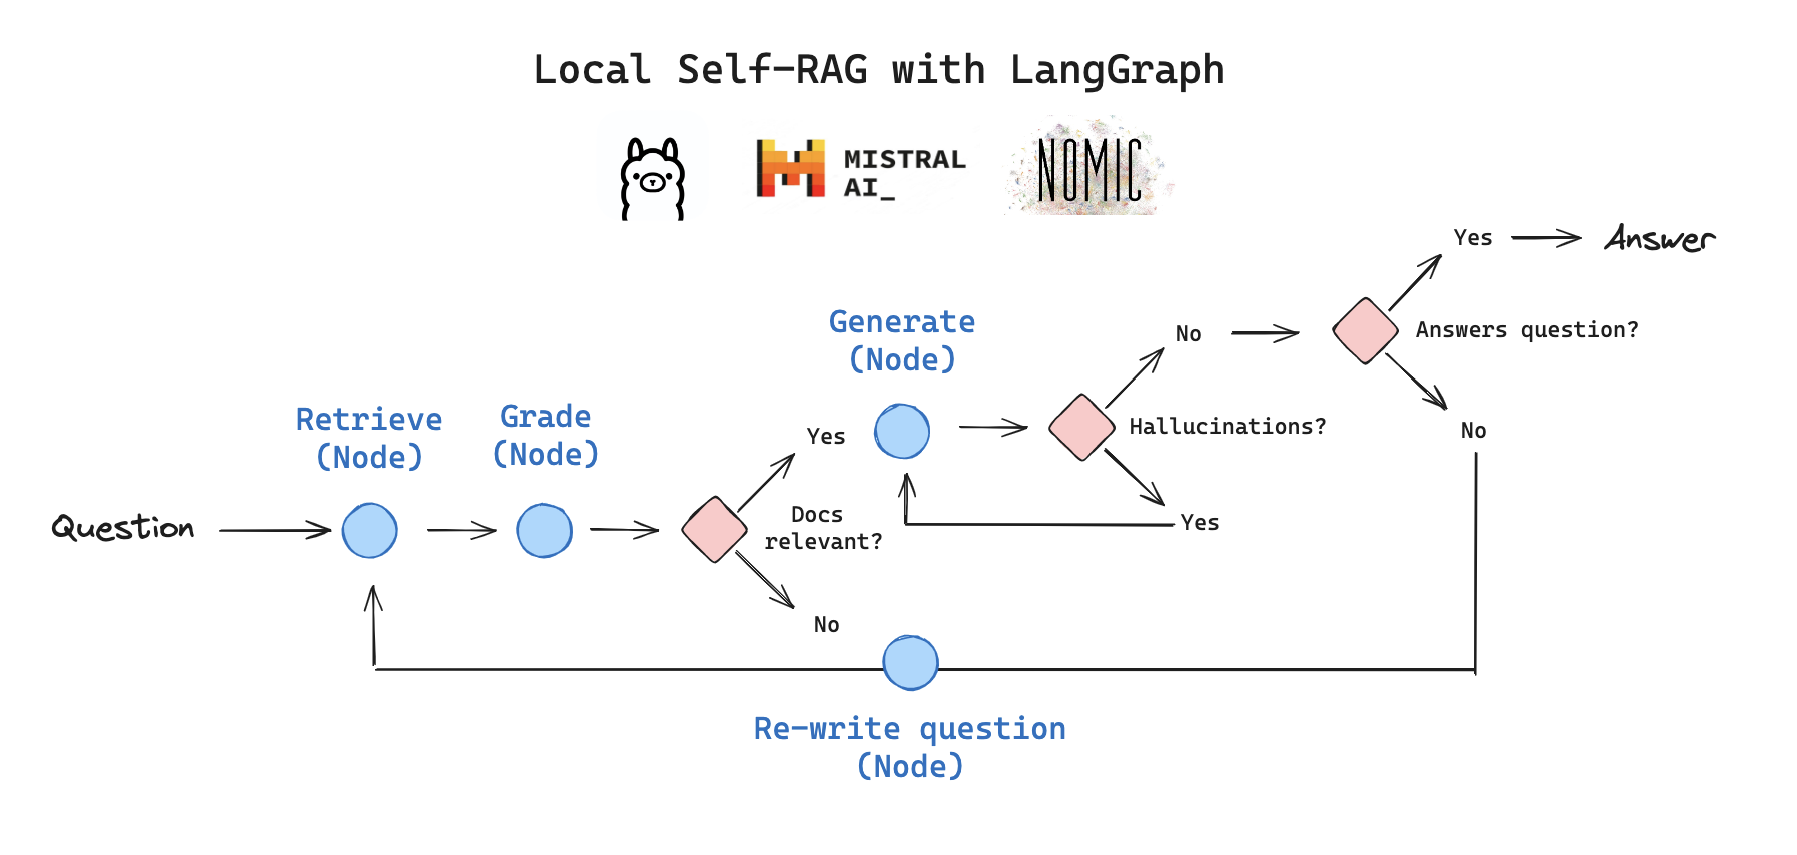

### Embeddings

We'll use Nomic's recently released [v1](https://blog.nomic.ai/posts/nomic-embed-text-v1) and [v1.5](https://blog.nomic.ai/posts/nomic-embed-matryoshka) embeddings.

Simply: 

(1) Clone [`llama.cpp`](https://github.com/ggerganov/llama.cpp):

```
git clone https://github.com/ggerganov/llama.cpp
```

(2) Download GGUF weights for Nomic's embedding model(s), allowing them to be run locally: 

* https://huggingface.co/nomic-ai/nomic-embed-text-v1-GGUF
* https://huggingface.co/nomic-ai/nomic-embed-text-v1.5-GGUF

(3) Add to `llama.cpp/model` directory.

(4) Build llama.cpp:
```
cd llama.cpp
make
```

### LLM

(1) Download [Ollama app](https://ollama.ai/).

(2) Download a `Mistral` model from various Mistral versions [here](https://ollama.ai/library/mistral) and Mixtral versions [here](https://ollama.ai/library/mixtral) available.
```
ollama pull mistral:instruct
```

(3) Set `local_llm` to the model downloaded.

In [ ]:
! ollama pull mistral:instruct

In [43]:
# Ollama model name
local_llm = "mistral:instruct"

# Local embedding model paths (downloaded above)O
embd_model_path = "/Users/rlm/Desktop/Code/llama.cpp/models/nomic-embd/nomic-embed-text-v1.Q4_K_S.gguf"
# embd_model_path = "/Users/rlm/Desktop/Code/llama.cpp/models/nomic-embd/nomic-embed-text-v1.f16.gguf"
# embd_model_path = "/Users/rlm/Desktop/Code/llama.cpp/models/nomic-embd/nomic-embed-text-v1.5.f16.gguf"
# embd_model_path = "/Users/rlm/Desktop/Code/llama.cpp/models/nomic-embd/nomic-embed-text-v1.5.Q4_K_S.gguf"

## Indexing

First, let's index a popular blog post on agents. 

For local, we can use Nomic's recently released [v1](https://blog.nomic.ai/posts/nomic-embed-text-v1) and [v1.5](https://blog.nomic.ai/posts/nomic-embed-matryoshka) embeddings.

We'll use the [llama.cpp](https://github.com/ggerganov/llama.cpp) integration.

We'll use a local vectorstore, [Chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma).

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import LlamaCppEmbeddings
from langchain_nomic.embeddings import NomicEmbeddings

# Load
url = "https://lilianweng.github.io/posts/2023-06-23-agent/"
loader = WebBaseLoader(url)
docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=100
)
all_splits = text_splitter.split_documents(docs)

# Embed and index
embedding = LlamaCppEmbeddings(model_path=embd_model_path, n_batch=512)

# Index
vectorstore = Chroma.from_documents(
    documents=all_splits,
    collection_name="rag-chroma",
    embedding=embedding,
)
retriever = vectorstore.as_retriever()

## State

Every node in our graph will modify `state`, which is dict that contains values (`question`, `documents`, etc) relevant to RAG.

In [44]:
from typing import Dict, TypedDict

from langchain_core.messages import BaseMessage


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        keys: A dictionary where each key is a string.
    """

    keys: Dict[str, any]

### Nodes and Edges

Every node in the graph we laid out above is a function.

Each node will modify the state in some way.

Each edge will choose which node to call next.

In [45]:
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
from langchain.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

### Nodes ###


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = retriever.get_relevant_documents(question)
    return {"keys": {"documents": documents, "question": question}}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOllama(model=local_llm, temperature=0)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {
        "keys": {"documents": documents, "question": question, "generation": generation}
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with relevant documents
    """

    print("---CHECK RELEVANCE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # LLM
    llm = ChatOllama(model=local_llm, format="json", temperature=0)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keywords related to the user question, grade it as relevant. \n
        It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
        Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
        input_variables=["question","context"],
    )

    # Chain
    chain = prompt | llm | JsonOutputParser()

    # Score
    filtered_docs = []
    for d in documents:
        score = chain.invoke(
            {
                "question": question,
                "context": d.page_content,
            }
        )
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue

    return {"keys": {"documents": filtered_docs, "question": question}}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # LLM
    llm = ChatOllama(model=local_llm, temperature=0)
    
    # Create a prompt template with format instructions and the query
    prompt = PromptTemplate(
        template="""You are generating questions that is well optimized for retrieval. \n 
        Look at the input and try to reason about the underlying sematic intent / meaning. \n 
        Here is the initial question:
        \n ------- \n
        {question} 
        \n ------- \n
        Formulate an improved question:""",
        input_variables=["question"],
    )

    # Chain
    chain = prompt | llm | StrOutputParser()
    better_question = chain.invoke({"question": question})

    return {"keys": {"documents": documents, "question": better_question}}


def prepare_for_final_grade(state):
    """
    Passthrough state for final grade.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): The current graph state
    """

    print("---FINAL GRADE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    generation = state_dict["generation"]

    return {
        "keys": {"documents": documents, "question": question, "generation": generation}
    }


### Edges ###


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Next node to call
    """

    print("---DECIDE TO GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    filtered_documents = state_dict["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TRANSFORM QUERY---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents(state):
    """
    Determines whether the generation is grounded in the document.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Binary decision
    """

    print("---GRADE GENERATION vs DOCUMENTS---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    generation = state_dict["generation"]

    # LLM
    llm = ChatOllama(model=local_llm, format="json", temperature=0)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
        Here are the facts:
        \n ------- \n
        {documents} 
        \n ------- \n
        Here is the answer: {generation}
        Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
        Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
        input_variables=["generation", "documents"],
    )

    # Chain
    chain = prompt | llm | JsonOutputParser()
    score = chain.invoke({"generation": generation, "documents": documents})
    grade = score["score"]

    if grade == "yes":
        print("---DECISION: SUPPORTED, MOVE TO FINAL GRADE---")
        return "supported"
    else:
        print("---DECISION: NOT SUPPORTED, GENERATE AGAIN---")
        return "not supported"


def grade_generation_v_question(state):
    """
    Determines whether the generation addresses the question.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Binary decision
    """

    print("---GRADE GENERATION vs QUESTION---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]
    generation = state_dict["generation"]

    llm = ChatOllama(model=local_llm, format="json", temperature=0)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing whether an answer is useful to resolve a question. \n 
        Here is the answer:
        \n ------- \n
        {generation} 
        \n ------- \n
        Here is the question: {question}
        Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
        Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
        input_variables=["generation", "question"],
    )

    # Prompt
    chain = prompt | llm | JsonOutputParser()
    score = chain.invoke({"generation": generation, "question": question})
    grade = score["score"]

    if grade == "yes":
        print("---DECISION: USEFUL---")
        return "useful"
    else:
        print("---DECISION: NOT USEFUL---")
        return "not useful"

## Build Graph

This just follows the flow we outlined in the figure above.

In [46]:
import pprint

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("prepare_for_final_grade", prepare_for_final_grade)  # passthrough

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents,
    {
        "supported": "prepare_for_final_grade",
        "not supported": "generate",
    },
)
workflow.add_conditional_edges(
    "prepare_for_final_grade",
    grade_generation_v_question,
    {
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

## Run

Trace for below run: https://smith.langchain.com/public/928651fd-85b3-49ff-b481-bd28417645e5/r

In [47]:
# Run
inputs = {"keys": {"question": "Explain how the different types of agent memory work?"}}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value['keys']['generation'])


llama_print_timings:        load time =     149.49 ms
llama_print_timings:      sample time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings: prompt eval time =      17.39 ms /    12 tokens (    1.45 ms per token,   690.01 tokens per second)
llama_print_timings:        eval time =       0.00 ms /     1 runs   (    0.00 ms per token,      inf tokens per second)
llama_print_timings:       total time =      17.39 ms /    13 tokens


---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK RELEVANCE---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
"Node 'grade_documents':"
'\n---\n'
---DECIDE TO GENERATE---
---DECISION: GENERATE---
---GENERATE---
"Node 'generate':"
'\n---\n'
---GRADE GENERATION vs DOCUMENTS---
---DECISION: SUPPORTED, MOVE TO FINAL GRADE---
---FINAL GRADE---
"Node 'prepare_for_final_grade':"
'\n---\n'
---GRADE GENERATION vs QUESTION---
---DECISION: USEFUL---
"Node '__end__':"
'\n---\n'
(' In a LLM (large language model)-powered autonomous agent system, LLM '
 'functions as the agent’s brain, complemented by several key components. One '
 'of these components is memory. Memory can be defined as the processes used '
 'to acquire, store, retain, and later retrieve information. There are several '
 'types of memory in human brains:\n'
 '\n'
 '1. Sensory Memory: This is the earliest stage of memory, providing the '
 'ability to ret